# Sanity checks
Some group-level analyses.

In [1]:
import numpy as np
import pandas as pd
import joblib as jl
import nibabel as nib
import os.path as op
import matplotlib.pyplot as plt
from glob import glob
from nilearn import plotting, masking, image
from nistats.first_level_model import FirstLevelModel
from nistats.second_level_model import SecondLevelModel
from nilearn.datasets import load_mni152_template
from nistats.thresholding import map_threshold

%matplotlib inline

mni = load_mni152_template()

/opt/conda/lib/python3.6/site-packages/nilearn/plotting/__init__.py:20: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


## Face perception

In [2]:
def run_firstlevels(task, space='MNI152NLin2009cAsym', event_col=None, conf_cols=None, n_jobs=1, n_subs=None, **flm_kwargs):

    if conf_cols is None:
        conf_cols = []
        
    if event_col is None:
        event_col = 'trial_type'

    LOG_DIR = op.join('..', '..', 'logs')
    BIDS_DIR = '..'
    FP_DIR = op.join(BIDS_DIR, 'derivatives', 'fmriprep')
    
    funcs = sorted(glob(op.join(FP_DIR, 'sub-*', 'func', f'*task-{task}*space-{space}*bold.nii.gz')))
    masks = sorted(glob(op.join(FP_DIR, 'sub-*', 'func', f'*task-{task}*space-{space}*brain_mask.nii.gz')))
    confs = sorted(glob(op.join(FP_DIR, 'sub-*', 'func', f'*task-{task}*regressors.tsv')))
    
    all_mri_subs = [op.basename(f).split('_')[0] for f in funcs]
    events = sorted(glob(op.join(LOG_DIR, task, 'clean', '*.tsv')))
    all_log_subs = [op.basename(f).split('_')[0] for f in events]
    all_compl_subs = list(set(all_mri_subs) & set(all_log_subs))

    events = [f for f in events if op.basename(f).split('_')[0] in all_compl_subs]
    funcs = [f for f in funcs if op.basename(f).split('_')[0] in all_compl_subs]
    masks = [f for f in masks if op.basename(f).split('_')[0] in all_compl_subs]
    confs = [f for f in confs if op.basename(f).split('_')[0] in all_compl_subs]

    if n_subs is None:
        n_subs = len(confs)
    
    if 'hrf_model' not in flm_kwargs.keys():
        flm_kwargs['hrf_model'] = 'glover'
        
    if 'noise_model' not in flm_kwargs.keys():
        flm_kwargs['noise_model'] = 'ols'
        
    if 'smoothing_fwhm' not in flm_kwargs.keys():
        flm_kwargs['smoothing_fwhm'] = 5
    
    flms = jl.Parallel(n_jobs=n_jobs)(jl.delayed(_fit_parallel)(
            func, mask, conf, event, conf_cols, event_col, **flm_kwargs
        ) for func, mask, conf, event in zip(funcs[:n_subs], masks[:n_subs], confs[:n_subs], events[:n_subs])
    )
    
    return flms

def _fit_parallel(func, mask, conf, event, conf_cols, event_col, **flm_kwargs):
    print("Fitting %s" % op.basename(func))   

    sub_ids = [op.basename(f).split('_')[0] for f in [func, mask, conf, event]]
    if len(set(sub_ids)) != 1:
        raise ValueError('Not aligned!')
        
    conf = pd.read_csv(conf, sep='\t')
    cols2idx = [col for col in conf.columns if 'Cosine' in col]
    conf = conf.loc[:, cols2idx + conf_cols + ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
    conf = conf.fillna(0)
    
    event = pd.read_csv(event, sep='\t')
    event.loc[:, 'trial_type'] = event.loc[:, event_col]
    event = event.loc[~event.trial_type.isna(), :]
    
    flm = FirstLevelModel(
        t_r=nib.load(func).header['pixdim'][4],
        drift_model=None,
        mask_img=mask,
        **flm_kwargs
    )
    
    flm.fit(func, confounds=conf, events=event)
    return flm

def run_grouplevel(flms, contrast):
    
    filt_flms = []
    str_contrast = ''.join([i for i in contrast if not i.isdigit()])
    cols = str_contrast.replace('*', '').replace('-', '').split('+')
    
    for flm in flms:
        dm_cols = flm.design_matrices_[0].columns.tolist()
        if all(col in dm_cols for col in cols):
            filt_flms.append(flm)

    slm = SecondLevelModel()
    slm.fit(filt_flms)
    img = slm.compute_contrast(first_level_contrast=contrast)
    return img

In [3]:
flms = run_firstlevels(
    task='workingmemory', space='MNI',
    conf_cols=['csf'], 
    event_col='trial_type',
    n_jobs=40,
    n_subs=40
)

Fitting sub-0014_task-workingmemory_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0015_task-workingmemory_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0010_task-workingmemory_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0012_task-workingmemory_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0019_task-workingmemory_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0013_task-workingmemory_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0018_task-workingmemory_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0021_task-workingmemory_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0020_task-workingmemory_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0027_task-workingmemory_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0028_task-workingmemory_acq-seq_space-

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

In [4]:
wm_img = run_grouplevel(flms, 'active_change+active_nochange+passive*-2')
wm_img_thr, cutoff = map_threshold(
    stat_img=wm_img,
    height_control='fdr',
    alpha=0.005
)
plotting.view_img(wm_img_thr)

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/opt/conda/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


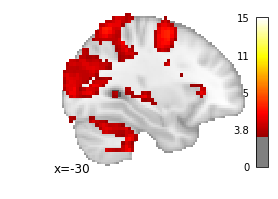

In [10]:
plotting.plot_stat_map(
    wm_img_thr,
    threshold=cutoff,
    display_mode='x',
    cut_coords=[-30],
    colorbar=True,
    vmax=15
)
plt.tight_layout()

In [23]:
flms_gs = run_firstlevels(
    task='gstroop', space='MNI',
    conf_cols=['csf'], 
    event_col='response_type',
    n_jobs=40,
    n_subs=None
)

Fitting sub-0018_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0015_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0019_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0020_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0021_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0022_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0024_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0023_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0026_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0028_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0027_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0029_task

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

Fitting sub-0056_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0058_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0059_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0060_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0061_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0062_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0063_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0064_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0065_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0066_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0067_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0068_task

Fitting sub-0157_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0158_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0159_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0166_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0168_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0169_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0170_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0171_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0172_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0173_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0175_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0177_task

In [24]:
gs_img = run_grouplevel(flms_gs, 'incorrect+correct*-1')
gs_img_thr, cutoff = map_threshold(
    stat_img=gs_img,
    height_control='fdr',
    alpha=0.005
)
plotting.view_img(gs_img_thr)

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/opt/conda/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


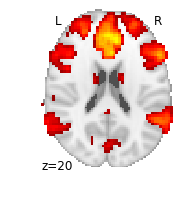

In [26]:
plotting.plot_stat_map(
    gs_img_thr,
    threshold=cutoff,
    display_mode='z',
    cut_coords=[20],
    colorbar=False,
    vmax=15
)

In [19]:
flms_emo = run_firstlevels(
    task='emorecognition', space='MNI',
    conf_cols=['csf'], 
    event_col='event_type',
    n_jobs=40,
    n_subs=None
)

Fitting sub-0012_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0010_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0019_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0020_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0021_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0022_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0023_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0024_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0027_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0025_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0026_task-emorecognition_acq

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

Fitting sub-0014_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

Fitting sub-0056_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0058_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0059_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0060_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0061_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0062_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0063_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0064_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0065_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0066_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0067_task-emorecognition_acq

Fitting sub-0147_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0148_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0149_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0151_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0152_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0153_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0154_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0155_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0157_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0158_task-emorecognition_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0159_task-emorecognition_acq

In [21]:
emo_img = run_grouplevel(flms_emo, 'emotion+control*-1')
emo_img_thr, cutoff = map_threshold(
    stat_img=emo_img,
    height_control='fdr',
    alpha=0.005
)
plotting.view_img(faces_img_thr)

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/opt/conda/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


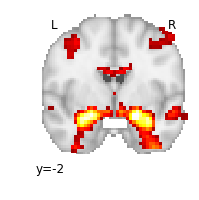

In [22]:
plotting.plot_stat_map(
    emo_img_thr,
    threshold=cutoff,
    display_mode='y',
    cut_coords=[-2],
    colorbar=False,
    vmax=15
)

In [27]:
flms_faces = run_firstlevels(
    task='faces', space='MNI',
    conf_cols=['csf'], 
    event_col='trial_type',
    n_jobs=40,
    n_subs=None
)

Fitting sub-0018_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0019_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0020_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0015_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0021_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0022_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0023_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0024_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0025_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0026_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0027_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0029_task-faces_acq-mb3_space-M

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

Fitting sub-0058_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0059_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0060_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0061_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0062_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0063_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0064_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0065_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0066_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0067_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0068_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0069_task-faces_acq-mb3_space-M

Fitting sub-0166_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0169_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0170_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0171_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0172_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0173_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0175_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0177_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0178_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0181_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0182_task-faces_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Fitting sub-0183_task-faces_acq-mb3_space-M

In [72]:
cons = []
for flm in flms_faces:
    con = flm.compute_contrast('anger-neutral', output_type='effect_size')
    con = image.resample_to_img(source_img=con, target_img=mni)
    cons.append(con)

slm = SecondLevelModel()
dm = pd.DataFrame(np.ones(len(cons)), columns=['icept'])
slm.fit(cons, design_matrix=dm)

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cach

SecondLevelModel(mask_img=None, memory=Memory(location=None), memory_level=1,
         minimize_memory=True, n_jobs=1, smoothing_fwhm=None, verbose=0)

In [74]:
plotting.view_img(
    map_threshold(
        slm.compute_contrast('icept'),
        height_control='fdr',
        alpha=0.005
    )[0]
)

/opt/conda/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/opt/conda/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/opt/conda/lib/python3.6/site-packages/nilearn/plotting/js_plotting_utils.py:100: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than 10 '
